In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Intro to Regression

We're going to start with synthetic data $(x_i,y_i)$, where $\{x_i\}$ are known with negligible uncertainty, and $\{y_i\}$ values have variable uncertainties $\{\sigma_{yi}\}$.  This data is from [](), and can be downloaded directly with the following:

```bash
wget -o ../data/data_yerr.dat https://raw.githubusercontent.com/davidwhogg/DataAnalysisRecipes/master/straightline/src/data_yerr.dat
```

In [2]:
data = np.genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

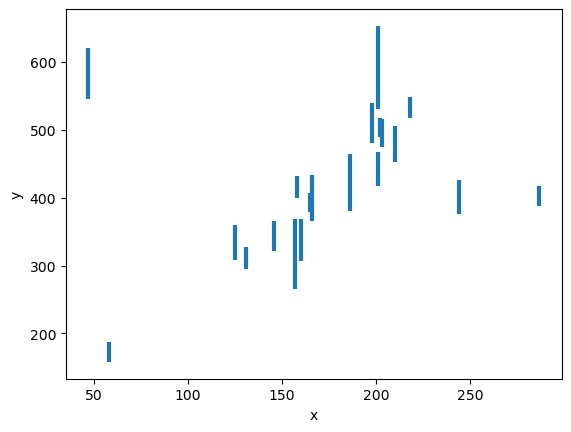

In [3]:
plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3)
plt.xlabel('x')
plt.ylabel('y');

If our goal is *linear regression*, we want to find the function $f(x)$ of the form

$$
f(x) = m x + b
$$

that best fits the data.

We'll start off with the following set of assumptions:
1. That the data truly come from a line, $y = f(x) = mx+b$.
1. Deviations from the *true* values are only due to errors in the measurement of $y$.
1. Those errors are drawn from Gaussian distributions, with $0$ mean and $\sigma_{y_i}^2$ variances (i.e., $\mathcal{N}(0, \sigma_{y_i}^2)$).
1. All errors are independent.

So, given independent $x_i$, uncertainties $\sigma_{y_i}$, a slope $m$, an intercept $b$, the distribution of expected values for $y_i$ follows

$$
p(y_i|x_i, \sigma_{y_i}, m, b) = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}}\exp{-\frac{[y_i - (mx_i + b)]^2}{2\sigma_{y_i}^2}},
$$

With this model, we can now determine the line (i.e., parameters $m$ and $b$) that maximizes the probability of the observed data given the model, or the *likelihood*.  Since all data points are assumed to be independent, so the likelihood $\mathcal{L}$ is just the product of the conditional probabilities.

$$
\mathcal{L} = \prod_{i=1}^N p(y_i|x_i, \sigma_{y_i}, m, b)
$$

It's often convinient to work with the log of probabilities, where

$$
\ln \mathcal{L} = K - \sum_{i=1}^N\frac{[y_i - (mx_i-b)]^2}{2\sigma_{y_i}^2} = K - \frac{1}{2}\chi^2
$$

Looking at this, we can see that maximizing the likelihood is equivilent to minimizing the $\chi^2$ (i.e., the total squared error, scaled by the uncertainties).

In [4]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, x=data['x'], y=data['y'], sigma_y=data['sigm_y']):
    model = build_model(m, b)
    lnlike = -.5*np.sum(np.log(2*np.pi*sigma_y**2)) - np.sum((y - model(x))**2/(2*sigma_y**2)) 
    return lnlike

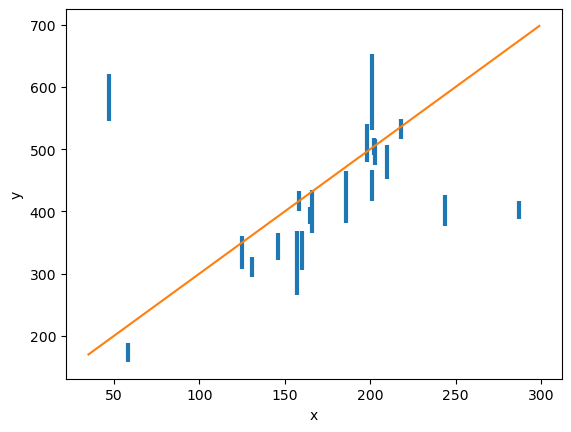

In [5]:
plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3)
plt.xlabel('x')
plt.ylabel('y')

xlow, xhigh = plt.xlim()
test_x = np.linspace(xlow, xhigh, 10)

m = 2
b = 100
model = build_model(m, b)
plt.plot(test_x, model(test_x));

In [6]:
from scipy.optimize import minimize

In [7]:
x0 = np.array([m, b])
res = minimize(lambda x:-lnlikelihood(x[0], x[1]), x0)

best_fit_m = res.x[0]
best_fit_b = res.x[1]
best_fit_model = build_model(best_fit_m, best_fit_b)

print("best fit model:\ny = {:.2f} x + {:.2f}".format(best_fit_m, best_fit_b))

best fit model:
y = 1.08 x + 213.27


max likelihood: 1.9292715699605403e-99


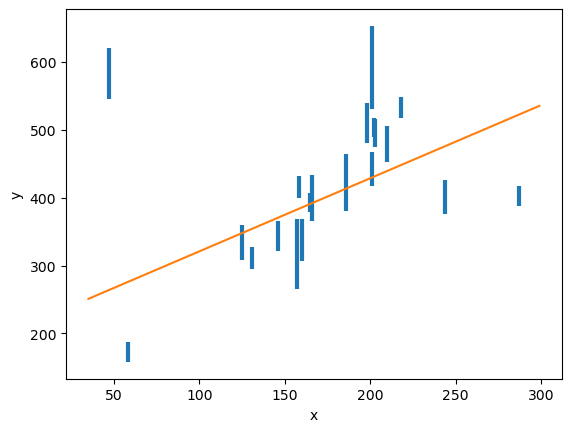

In [8]:
plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3)
plt.xlabel('x')
plt.ylabel('y')

plt.plot(test_x, best_fit_model(test_x))
print("max likelihood: {}".format(np.exp(lnlikelihood(best_fit_m, best_fit_b))))

For fun, lets look at the likelihood surface over a range of parameter values around the best-fit point.

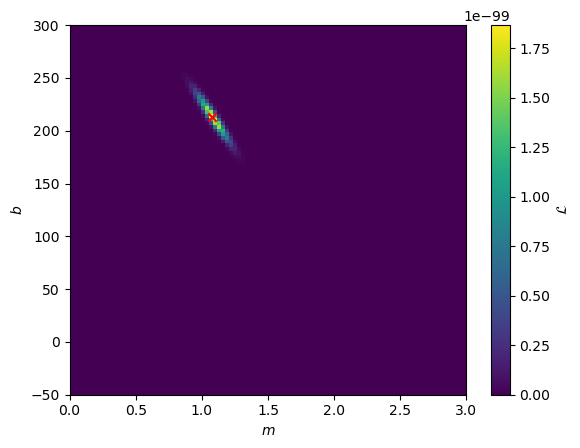

In [9]:
ngrid = 100

mmin, mmax = 0, 3
bmin, bmax = -50, 300
ms = np.linspace(mmin, mmax, ngrid)
bs = np.linspace(bmin, bmax, ngrid)

M, B = np.meshgrid(ms, bs)
pts = np.column_stack([M.ravel(), B.ravel()])
lnL = np.array([lnlikelihood(m, b) for m,b in pts]).reshape(M.shape)
plt.imshow(np.exp(lnL), extent=[mmin, mmax, bmin, bmax], origin='lower', aspect='auto')
plt.xlabel('$m$')
plt.ylabel('$b$')

cbar = plt.colorbar()
cbar.set_label('$\mathcal{L}$')

plt.scatter([best_fit_m], [best_fit_b], marker='x', color='r');